In [1]:
import polars as pl
import numpy as np
from typing import List

def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # ËßÇÊµãÂô™Â£∞ÂçèÊñπÂ∑ÆÔºàË∂äÂ∞èË∂ä‰ø°Ôºâ
        Q: float = 1e-5   # ËøáÁ®ãÂô™Â£∞ÂçèÊñπÂ∑ÆÔºàË∂äÂ∞èË∂äÁ®≥Ôºâ
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)      # ‰º∞ËÆ°ÂÄº
    P = np.zeros(n)          # ‰º∞ËÆ°ËØØÂ∑ÆÂçèÊñπÂ∑Æ
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # È¢ÑÊµãÊõ¥Êñ∞
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # ËßÇÊµãÊõ¥Êñ∞
        K = P_minus / (P_minus + R)  # Âç°Â∞îÊõºÂ¢ûÁõä
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)

# Âà§Êñ≠Â∫èÂàóÊòØÊî∂Êïõ„ÄÅÂèëÊï£ËøòÊòØÊ∑∑Ê≤åÁ≥ªÁªüÔºö
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)

def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1 : i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)

def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series

def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")

def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # ‰∫åÈò∂Â∑ÆÂàÜ = ‰∏ÄÈò∂Â∑ÆÂàÜÁöÑÂ∑ÆÂàÜ
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # Âä®ÈáèÊØîÁéá = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")

def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")

def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")

def spread_product_expr(a: str, b: str) -> pl.Expr:
    return ((pl.col(a) - pl.col(b)) * (pl.col(a) + pl.col(b))).alias(f"{a}_SPREAD_X_MAG_{b}")

def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
        ])

    return single_exprs

def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b,),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [ ]:
import polars as pl


def cal_z_score(x: pl.Expr, mean: pl.Expr, std: pl.Expr) -> pl.Expr:
    return (x - mean) / std


def scaled_sigmoid_expr(x: pl.Expr, start: pl.Expr, end: pl.Expr) -> pl.Expr:
    n = (start - end).abs()
    score = pl.lit(2) / (
            pl.lit(1) + (pl.lit(2.71828) ** (-pl.lit(40_0000).log(10) * ((x - start - n) / n) + pl.lit(5e-3).log(10)))
    )
    return score / pl.lit(2)


def rolling_scaled_sigmoid_expr(x: str, mean: str, std: str) -> pl.Expr:
    return (
        pl.when(pl.col(std) == 0)
        .then(pl.lit(0.5))
        .otherwise(
            scaled_sigmoid_expr(cal_z_score(pl.col(x), pl.col(mean), pl.col(std)), pl.lit(-2.), pl.lit(2.))
        )
        .alias(f"{x}_scaled")  # ÂàóÂëΩÂêç
    )

def rolling_sum_expr(col_name: str, window: int) -> pl.Expr:
    return pl.col(col_name).rolling_sum(window).alias(f"{col_name}_sum_{window}")

def rolling_normalize_data(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
           and not (col.endswith('_rolling_mean') or col.endswith('_rolling_std') or col.endswith('_scaled'))
    ]

    normalized_df = rollin_df.with_columns(
        [
            pl.col(column).rolling_mean(window).alias(f"{column}_rolling_mean")
            for column in columns_to_normalize
        ] + [
            pl.col(column).rolling_std(window).alias(f"{column}_rolling_std")
            for column in columns_to_normalize
        ]
    ).with_columns(
        rolling_scaled_sigmoid_expr(column, f"{column}_rolling_mean", f"{column}_rolling_std")
        for column in columns_to_normalize
    )
    return normalized_df

In [2]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # Êñ∞Â¢û datetime ÂàóÔºå‰∏çË¶ÜÁõñÂéüÂßãÊó∂Èó¥Êà≥
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # ÊåâÂë®Êà™Êñ≠ÔºåÁî®Êñ∞ÁöÑ datetime Âàó
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1").alias("week_start")
    ])

    # Ëé∑ÂèñÂîØ‰∏ÄÂë®
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # ÊØèÂë®Á≠õÈÄâÂ≠ê DataFrameÔºå‰øùÁïôÊâÄÊúâÂàó
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def split_df_by_month(
        df: pl.DataFrame, 
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        df.filter(pl.col("month_start") == mo).drop("month_start")
        for mo in unique_months["month_start"]
    ]

    return monthly_dfs


In [3]:
import pandas as pd

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 3000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()
    
    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("ÂêÑÂàóÁ©∫ÂÄºÊï∞ÈáèÔºö")
        print(null_counts[null_counts > 0])
        print(f"Âà†Èô§Á©∫ÂÄºË∂ÖËøá {null_threshold} ÁöÑÂàóÔºö{list(cols_to_drop)}")
        print(f"Âà†Èô§ÂàóÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö{pd_df_cleaned.shape}")
        print(f"Á©∫ÂÄºÊúÄÂ§öÁöÑÂàóÊòØÔºö{max_null_col}ÔºåÂÖ±Êúâ {max_null_count} ‰∏™Á©∫ÂÄº")
        print(f"Âà†Èô§Á©∫ÂÄºË°åÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö{pd_df_clean.shape}")

    return pl_df_clean

In [4]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.0005_rolling200.csv")

In [5]:
# ÂÅáËÆæ‰Ω†Â∑≤Êúâ df
monthly_dataframes = split_df_by_month(origin_df)
print(f"ÂÖ±ÊãÜÊàê {len(monthly_dataframes)} ‰∏™ÊúàÊï∞ÊçÆÂ∏ß")


ÂÖ±ÊãÜÊàê 2 ‰∏™ÊúàÊï∞ÊçÆÂ∏ß


In [6]:
monthly_dataframes[0]

shape: (55_549, 41)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ impact_sensitivity   ‚îÜ momentum_confirmed_ ‚îÜ oi_breakout_signal  ‚îÜ timestamp_dt ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                  ‚îÜ by_orderflo‚Ä¶        ‚îÜ ---                 ‚îÜ ---          ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ f64                  ‚îÜ ---                 ‚îÜ f64                 ‚îÜ datetime[Œºs] ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ f64                 ‚îÜ                     ‚îÜ              ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1743939741056000 ‚îÜ 82724.9 ‚îÜ 63.539       ‚îÜ 7.48          ‚îÜ ‚Ä¶ ‚îÜ -0.000132            ‚îÜ -0.007396           ‚îÜ 8.7937e-8           ‚îÜ 2025-04-06   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 11:42:21.056 ‚îÇ
‚îÇ 1743940210475000 ‚îÜ 82680.1 ‚îÜ 395.821      ‚îÜ 259.278       ‚îÜ ‚Ä¶ ‚îÜ -0.000016            ‚îÜ -0.002175           ‚îÜ 0.000001            ‚îÜ 2025-04-06   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 11:50:10.475 ‚îÇ
‚îÇ 1743940436296000 ‚îÜ 82726.3 ‚îÜ 146.192      ‚îÜ 113.842       ‚îÜ ‚Ä¶ ‚îÜ -0.000036            ‚îÜ -0.001164           ‚îÜ 3.2082e-7           ‚îÜ 2025-04-06   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 11:53:56.296 ‚îÇ
‚îÇ 1743940481646000 ‚îÜ 82767.8 ‚îÜ 106.737      ‚îÜ 14.847        ‚îÜ ‚Ä¶ ‚îÜ -0.000068            ‚îÜ -0.006294           ‚îÜ 1.1893e-7           ‚îÜ 2025-04-06   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 11:54:41.646 ‚îÇ
‚îÇ 1743940493529000 ‚îÜ 82814.9 ‚îÜ 75.054       ‚îÜ 3.979         ‚îÜ ‚Ä¶ ‚îÜ -0.000105            ‚îÜ -0.007438           ‚îÜ 7.6244e-8           ‚îÜ 2025-04-06   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 11:54:53.529 ‚îÇ
‚îÇ ‚Ä¶                ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶                    ‚îÜ ‚Ä¶                   ‚îÜ ‚Ä¶                   ‚îÜ ‚Ä¶            ‚îÇ
‚îÇ 1746056768281000 ‚îÜ 94154.0 ‚îÜ 53.762       ‚îÜ 29.545        ‚îÜ ‚Ä¶ ‚îÜ -0.000018            ‚îÜ -0.000438           ‚îÜ 2.3610e-9           ‚îÜ 2025-04-30   ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ                      ‚îÜ                     ‚îÜ                     ‚îÜ 23:46:08.281 ‚îÇ
‚îÇ 1746057039541000 ‚îÜ 94201.1 ‚îÜ 259.965      ‚îÜ 105.668       ‚îÜ ‚Ä¶ ‚îÜ -0.000004            ‚îÜ -0.000638           ‚îÜ 1.0413e-8           ‚îÜ 2025-04-30   ‚îÇ
‚îÇ                  ‚îÜ         ‚î

In [7]:
raw_df = batch_apply_transforms(monthly_dataframes[0], 200, 1)


In [8]:
print(f"Polars DataFrame size: {raw_df.estimated_size() / (1024 ** 2):.4f} MB")

raw_df

Polars DataFrame size: 1506.9986 MB


shape: (55_549, 3_551)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ momentum_confirmed ‚îÜ momentum_confirmed ‚îÜ momentum_confirme ‚îÜ momentum_confirme ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ _by_orderflo‚Ä¶      ‚îÜ _by_orderflo‚Ä¶      ‚îÜ d_by_orderflo‚Ä¶    ‚îÜ d_by_orderflo‚Ä¶    ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---               ‚îÜ ---               ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ f64                ‚îÜ f64                ‚îÜ f64               ‚îÜ f64               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1743939741056000 ‚îÜ 82724.9 ‚îÜ 63.539       ‚îÜ 7.48          ‚îÜ ‚Ä¶ ‚îÜ -6.5038e-10        ‚îÜ -75517.261408      ‚îÜ 0.000055          ‚îÜ 0.0               ‚îÇ
‚îÇ 1743940210475000 ‚îÜ 82680.1 ‚îÜ 395.821      ‚îÜ 259.278       ‚îÜ ‚Ä¶ ‚îÜ -2.1895e-9         ‚îÜ -2140.082016       ‚îÜ 0.000005          ‚îÜ 0.0               ‚îÇ
‚îÇ 1743940436296000 ‚îÜ 82726.3 ‚îÜ 146.192      ‚îÜ 113.842       ‚îÜ ‚Ä¶ ‚îÜ -3.7329e-10        ‚îÜ -3517.121409       ‚îÜ 0.000001          ‚îÜ 0.0               ‚îÇ
‚îÇ 1743940481646000 ‚îÜ 82767.8 ‚îÜ 106.737      ‚îÜ 14.847        ‚îÜ ‚Ä¶ ‚îÜ -7.4853e-10        ‚îÜ -48816.496824      ‚îÜ 0.00004           ‚îÜ 0.0               ‚îÇ
‚îÇ 1743940493529000 ‚îÜ 82814.9 ‚îÜ 75.054       ‚îÜ 3.979         ‚îÜ ‚Ä¶ ‚îÜ -5.6707e-10        ‚îÜ -86237.77828       ‚îÜ 0.000055          ‚îÜ 0.0               ‚îÇ
‚îÇ ‚Ä¶                ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                 ‚îÜ ‚Ä¶                 ‚îÇ
‚îÇ 1746056768281000 ‚îÜ 94154.0 ‚îÜ 53.762       ‚îÜ 29.545        ‚îÜ ‚Ä¶ ‚îÜ -1.0346e-12        ‚îÜ -35449.236688      ‚îÜ 1.9201e-7         ‚îÜ 0.0               ‚îÇ
‚îÇ 1746057039541000 ‚îÜ 94201.1 ‚îÜ 259.965      ‚îÜ 105.668       ‚îÜ ‚Ä¶ ‚îÜ -6.6389e-12        ‚îÜ -31234.303232      ‚îÜ 4.0651e-7         ‚îÜ 0.0               ‚îÇ
‚îÇ 1746057263664000 ‚îÜ 94153.9 ‚îÜ 89.971       ‚îÜ 132.777       ‚îÜ ‚Ä¶ ‚îÜ 9.1831e-12         ‚îÜ 17395.534026       ‚îÜ 2.4603e-7         ‚îÜ 0.0               ‚îÇ
‚îÇ 1746057329007000 ‚îÜ 94106.7 ‚îÜ 47.684       ‚îÜ 35.847        ‚îÜ ‚Ä¶ ‚îÜ -2.5314e-12        ‚îÜ -21581.095496      ‚îÜ 1.3348e-7         ‚îÜ 0.0               ‚îÇ
‚îÇ 1746057501031000 ‚îÜ 94155.0 ‚îÜ 61.829       ‚îÜ 66.076        ‚îÜ ‚Ä¶ ‚îÜ 1.9933e-13         ‚îÜ 3725.520149        ‚îÜ 2.6663e-9         ‚îÜ 0.0               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [9]:
from tqdm import tqdm

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
                
        if steps != -1:
            steps_list.append(steps)
            
    if len(steps_list) == 0:
        return -1
        
    return int(np.mean(steps_list))

prices_np = raw_df["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±2% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_2pct)


cal abs change 0.50% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 55549/55549 [00:00<00:00, 59657.81it/s]


Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞: 92


cal abs change 1.00% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 55549/55549 [00:03<00:00, 17408.21it/s]


Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞: 322


cal abs change 2.00% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 55549/55549 [00:13<00:00, 4244.63it/s]

Ê≥¢Âä® ¬±2% ÁöÑÂùáÂÄºÊ≠•Êï∞: 1259


In [10]:
avg_steps_2pct = 2000

In [11]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

raw_df = raw_df.with_columns([
    # future_return_expr("price", avg_steps_05pct),
    # future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [12]:
cleaned_df = clean_df_drop_nulls(raw_df)


ÂêÑÂàóÁ©∫ÂÄºÊï∞ÈáèÔºö
price_lyap_200                             199
price_fft_power_top3                       199
sum_buy_size_lyap_200                      199
sum_buy_size_fft_power_top3                199
sum_sell_size_lyap_200                     199
                                          ... 
oi_breakout_signal_second_order_diff_1       2
oi_breakout_signal_momentum_ratio_1          1
oi_breakout_signal_lag_1                     1
oi_breakout_signal_skew_shift_200          200
future_return_2000                        2000
Length: 391, dtype: int64
Âà†Èô§Á©∫ÂÄºË∂ÖËøá 3000 ÁöÑÂàóÔºö['alt_top_long_short_account_ratio_data_longShortRatio_skew_shift_200', 'oi_trend_slope_skew_shift_200']
Âà†Èô§ÂàóÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö(55549, 3550)
Á©∫ÂÄºÊúÄÂ§öÁöÑÂàóÊòØÔºöalt_top_long_short_account_ratio_data_longShortRatio_skew_shift_200ÔºåÂÖ±Êúâ 3724 ‰∏™Á©∫ÂÄº
Âà†Èô§Á©∫ÂÄºË°åÂêéÔºåDataFrameÂΩ¢Áä∂Ôºö(50078, 3550)


In [13]:
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol']


In [14]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str, exclude_prefixes: list[str]) -> dict:
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict


In [15]:
# ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_05pct}", exclude_prefixes)
# # Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
# sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

# print("Top 20 features by IC:")
# for feat, ic in sorted_ic[:20]:
#     print(f"{feat}: {ic:.6f}")

# print("\nBottom 20 features by IC:")
# for feat, ic in reversed(sorted_ic[-20:]):
#     print(f"{feat}: {ic:.6f}")


In [16]:
# ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_1pct}", exclude_prefixes)
# # Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
# sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

# print("Top 20 features by IC:")
# for feat, ic in sorted_ic[:20]:
#     print(f"{feat}: {ic:.6f}")

# print("\nBottom 20 features by IC:")
# for feat, ic in reversed(sorted_ic[-20:]):
#     print(f"{feat}: {ic:.6f}")


In [17]:
ic_results = fast_spearman_ic(cleaned_df, f"future_return_{avg_steps_2pct}", exclude_prefixes)
# Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


Calculating IC: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3547/3547 [00:02<00:00, 1457.57it/s]

Top 20 features by IC:
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.423164
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.422777
alt_factor_long_term_oi_trend_DIV_mid_price: 0.422356
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.421914
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.421210
alt_open_interest_data_sumOpenInterest_DIV_far_ask_price: 0.415667
alt_open_interest_data_sumOpenInterest_DIV_best_ask_price: 0.415486
alt_open_interest_data_sumOpenInterest_DIV_mid_price: 0.415218
alt_open_interest_data_sumOpenInterest_DIV_best_bid_price: 0.414938
alt_open_interest_data_sumOpenInterest_DIV_far_bid_price: 0.414575
alt_factor_short_term_oi_trend_DIV_far_ask_price: 0.394870
alt_factor_short_term_oi_trend_DIV_best_ask_price: 0.394566
alt_factor_short_term_oi_trend_DIV_mid_price: 0.394215
alt_factor_short_term_oi_trend_DIV_best_bid_price: 0.393845
alt_factor_short_term_oi_trend_DIV_far_bid_price: 0.393247
alt_open_interest_data_sumOpenInterest_SPREAD_X_MAG_far_ask_pri

In [18]:
def calc_hourly_rankic(
    df_to_cal_rankic: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df_to_cal_rankic.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]
    
    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"),
                    method="spearman").alias(factor)
        )
        
    ic_df = (
        df_to_cal_rankic
        .with_columns([
            pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us")),
        ])
        .with_columns([
            pl.col(timestamp_col).dt.truncate("1h").alias("hour_group"),
        ])
        .group_by("hour_group")
        .agg(agg_exprs)
        .sort("hour_group")
    )
    
    
    return ic_df

In [19]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    # ‰ΩøÁî® pl.DataFrame.select ÊâπÈáèËÆ°ÁÆó mean Âíå std
    means = ic_df.select([pl.col(col).mean().alias(col) for col in factor_cols])
    stds = ic_df.select([pl.col(col).std().alias(col) for col in factor_cols])

    # ÊûÑÈÄ†ÁªìÊûú
    data = []
    for col in factor_cols:
        mean_ic = means[0, col]
        std_ic = stds[0, col]
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": col, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})

    return pl.DataFrame(data)


In [20]:
target_col = f"future_return_{avg_steps_2pct}"

exclude_cols = exclude_prefixes + ['hour_group']

ic_hourly = calc_hourly_rankic(
    cleaned_df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


shape: (532, 3_548)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ hour_group   ‚îÜ price     ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ momentum_confirmed ‚îÜ momentum_confirmed ‚îÜ momentum_confirmed ‚îÜ momentum_confirmed ‚îÇ
‚îÇ ---          ‚îÜ ---       ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ _by_orderflo‚Ä¶      ‚îÜ _by_orderflo‚Ä¶      ‚îÜ _by_orderflo‚Ä¶      ‚îÜ _by_orderflo‚Ä¶      ‚îÇ
‚îÇ datetime[Œºs] ‚îÜ f64       ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---                ‚îÜ ---                ‚îÇ
‚îÇ              ‚îÜ   

In [21]:
def print_top_bottom_ic_ir(
    ic_summary: pl.DataFrame,
    top_n: int = 5
):
    pdf = ic_summary.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])
    
    def format_rows(rows, metric_name):
        max_len = max(len(row['factor']) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    ic_top = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient="records")
    ic_bottom = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient="records")
    ir_top = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient="records")
    ir_bottom = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient="records")

    print("üìà Top IC Factors:")
    print("\n".join(format_rows(ic_top, "mean_ic")), end="\n\n")

    print("üìâ Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom, "mean_ic")), end="\n\n")

    print("üìà Top IR Factors:")
    print("\n".join(format_rows(ir_top, "ir")), end="\n\n")

    # ÂêåÊó∂ËøîÂõûÂõ†Â≠êÂêçÂàóË°®ÔºàÂ¶ÇÈúÄËøõ‰∏ÄÊ≠•Êìç‰ΩúÔºâ
    ic_top_names = [row["factor"] for row in ic_top]
    ic_bot_names = [row["factor"] for row in ic_bottom]

    ir_top_names = [row["factor"] for row in ir_top]
    return ic_top_names, ic_bot_names, ir_top_names


In [22]:
ic_summary = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(ic_summary)
ic_top_rank, ic_bot_rank, ir_top_rank = print_top_bottom_ic_ir(ic_summary, top_n=10)


shape: (3_391, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ factor                          ‚îÜ mean_ic   ‚îÜ std_ic   ‚îÜ ir        ‚îÇ
‚îÇ ---                             ‚îÜ ---       ‚îÜ ---      ‚îÜ ---       ‚îÇ
‚îÇ str                             ‚îÜ f64       ‚îÜ f64      ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ sum_buy_size                    ‚îÜ -0.052802 ‚îÜ 0.244463 ‚îÜ -0.215993 ‚îÇ
‚îÇ sum_sell_size                   ‚îÜ 0.062726  ‚îÜ 0.233052 ‚îÜ 0.269152  ‚îÇ
‚îÇ price_pct_change                ‚îÜ -0.148963 ‚îÜ 0.194467 ‚îÜ -0.766006 ‚îÇ
‚îÇ buy_sell_imbalance              ‚îÜ -0.15078  ‚îÜ 0.268887 ‚îÜ -0.5607

In [23]:
cleaned_df


shape: (50_078, 3_550)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ momentum_confirmed ‚îÜ momentum_confirmed ‚îÜ momentum_confirme ‚îÜ future_return_200 ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ _by_orderflo‚Ä¶      ‚îÜ _by_orderflo‚Ä¶      ‚îÜ d_by_orderflo‚Ä¶    ‚îÜ 0                 ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---               ‚îÜ ---               ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ f64                ‚îÜ f64                ‚îÜ f64               ‚îÜ f64               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1743961808254000 ‚îÜ 81100.9 ‚îÜ 4.091        ‚îÜ 32.729        ‚îÜ ‚Ä¶ ‚îÜ 86968.007599       ‚îÜ 0.000165           ‚îÜ 1.7646e-9         ‚îÜ -0.043574         ‚îÇ
‚îÇ 1743961812617000 ‚îÜ 81060.0 ‚îÜ 2.154        ‚îÜ 38.085        ‚îÜ ‚Ä¶ ‚îÜ 91873.246262       ‚îÜ 0.000217           ‚îÜ 2.2154e-9         ‚îÜ -0.042608         ‚îÇ
‚îÇ 1743961821154000 ‚îÜ 81017.6 ‚îÜ 27.714       ‚îÜ 47.29         ‚îÜ ‚Ä¶ ‚îÜ 14825.433949       ‚îÜ 0.000019           ‚îÜ 0.0               ‚îÜ -0.042591         ‚îÇ
‚îÇ 1743961830519000 ‚îÜ 81058.3 ‚îÜ 64.137       ‚îÜ 21.993        ‚îÜ ‚Ä¶ ‚îÜ -25781.471238      ‚îÜ 0.000058           ‚îÜ -2.1576e-9        ‚îÜ -0.042472         ‚îÇ
‚îÇ 1743961839009000 ‚îÜ 81099.9 ‚îÜ 32.025       ‚îÜ 17.903        ‚îÜ ‚Ä¶ ‚îÜ -26638.915115      ‚îÜ 0.000017           ‚îÜ 0.0               ‚îÜ -0.042446         ‚îÇ
‚îÇ ‚Ä¶                ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                 ‚îÜ ‚Ä¶                 ‚îÇ
‚îÇ 1745870089735000 ‚îÜ 94781.2 ‚îÜ 133.3        ‚îÜ 208.035       ‚îÜ ‚Ä¶ ‚îÜ -6463.209986       ‚îÜ 0.000003           ‚îÜ 0.0               ‚îÜ -0.006617         ‚îÇ
‚îÇ 1745870340773000 ‚îÜ 94730.4 ‚îÜ 230.487      ‚îÜ 372.849       ‚îÜ ‚Ä¶ ‚îÜ -4594.267058       ‚îÜ 0.000003           ‚îÜ 0.0               ‚îÜ -0.005587         ‚îÇ
‚îÇ 1745870486153000 ‚îÜ 94681.3 ‚îÜ 250.927      ‚îÜ 248.922       ‚îÜ ‚Ä¶ ‚îÜ 93.964336          ‚îÜ 7.4210e-10         ‚îÜ 0.0               ‚îÜ -0.00557          ‚îÇ
‚îÇ 1745870545337000 ‚îÜ 94599.4 ‚îÜ 112.599      ‚îÜ 261.422       ‚îÜ ‚Ä¶ ‚îÜ -15056.003699      ‚îÜ 0.000005           ‚îÜ 0.0               ‚îÜ -0.005208         ‚îÇ
‚îÇ 1745871073157000 ‚îÜ 94550.0 ‚îÜ 589.267      ‚îÜ 652.988       ‚îÜ ‚Ä¶ ‚îÜ -615.827679        ‚îÜ 7.6813e-8          ‚îÜ 0.0               ‚îÜ -0.004178         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [24]:
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

def calc_monotonicity(bin_returns) -> float:
    bins = list(range(len(bin_returns)))
    rho, _ = spearmanr(bins, bin_returns)
    return rho

def calc_binned_return_and_stability(
    df: pl.DataFrame,
    future_return_col: str,
    exclude_prefixes: list[str] = None,
    n_bins: int = 50,
):
    if exclude_prefixes is None:
        exclude_prefixes = []

    factors = [
        col for col in df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    pdf = df.select([*factors, future_return_col]).to_pandas().dropna()

    results = []

    for factor in factors:
        try:
            pdf['factor_bin'] = pd.qcut(pdf[factor], q=n_bins, duplicates='drop')
            grouped = pdf.groupby('factor_bin', observed=False)[future_return_col].agg(['mean', 'std']).reset_index()

            if len(grouped) < 40:
                continue
                
            bin_means = grouped['mean'].tolist()
            spread = bin_means[-1] - bin_means[0]
            mean_std = grouped['std'].mean()
            mean_mean = grouped['mean'].mean()
            stability = mean_std / abs(mean_mean) if mean_mean != 0 else np.nan
            monotonicity = calc_monotonicity(bin_means)

            results.append({
                'factor': factor,
                'spread': spread,
                'stability': stability,
                'monotonicity': monotonicity,
                'mean_return_top_bin': bin_means[-1],
                'mean_return_bottom_bin': bin_means[0],
                'bin_returns': bin_means,
            })
            
        except Exception as e:
            print(f"Skipped factor {factor} due to error: {e}")
            continue

    results_sorted_by_spread = sorted(results, key=lambda x: x['spread'], reverse=True)
    results_sorted_by_stability = sorted(results, key=lambda x: x['stability'] if not np.isnan(x['stability']) else 1e9)
    results_sorted_by_monotonicity = sorted(results, key=lambda x: abs(x['monotonicity']), reverse=True)
    return {
        'by_spread': results_sorted_by_spread,
        'by_stability': results_sorted_by_stability,
        'by_monotonicity': results_sorted_by_monotonicity,
        'raw': results
    }


In [25]:
res = calc_binned_return_and_stability(cleaned_df, future_return_col=target_col, exclude_prefixes=exclude_cols, n_bins=50)

print("ÊåâÊî∂ÁõäÂ∑ÆÊéíÂêçTop 5Ôºö")
for r in res['by_spread'][:50]:
    print(r['factor'], r['spread'])

print("\nÊåâÂπ≥Á®≥Â∫¶ÊéíÂêçTop 5Ôºö")
for r in res['by_stability'][:50]:
    print(r['factor'], r['stability'])

print("\nÊåâÂçïË∞ÉÊÄßÊéíÂêçTop 5Ôºö")
for r in res['by_monotonicity'][:50]:
    print(r['factor'], r['monotonicity'])


ÊåâÊî∂ÁõäÂ∑ÆÊéíÂêçTop 5Ôºö
alt_top_long_short_position_ratio_data_longShortRatio_X_avg_sell_size_200 0.0450967562773818
sum_buy_size_kalman 0.04444728779801144
sum_sell_size_lyap_200 0.04389023237205787
oi_trend_slope_lyap_200 0.04354378295161904
sum_sell_size_kalman 0.04264179668471116
alt_top_long_short_position_ratio_data_longShortRatio_X_avg_buy_size_200 0.04182167460344837
alt_factor_short_term_oi_trend_volatility_200 0.04132112543254211
avg_buy_size_200_SPREAD_X_MAG_impact_sensitivity 0.04101543312690669
avg_buy_size_200 0.040998373617789574
avg_buy_size_200_squared 0.040998373617789574
avg_buy_size_200_abs 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_rolling_px_pct_sum_200 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_momentum_confirmed_by_orderflow 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_oi_breakout_signal 0.040998373617789574
avg_buy_size_200_SPREAD_X_MAG_impact_momentum 0.0409

In [26]:
A = ['alt_open_interest_data_sumOpenInterestValue_fft_power_top3', 'alt_open_interest_data_sumOpenInterestValue', 'alt_open_interest_data_sumOpenInterestValue_X_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'mid_price', 'alt_factor_long_term_oi_trend_X_far_bid_price']
FC = 'price_volatility_200'

47.699497809661665 909.6882227513845


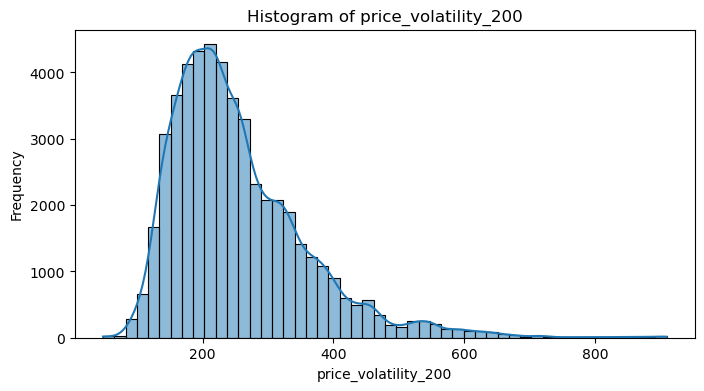

74487.6 95752.2


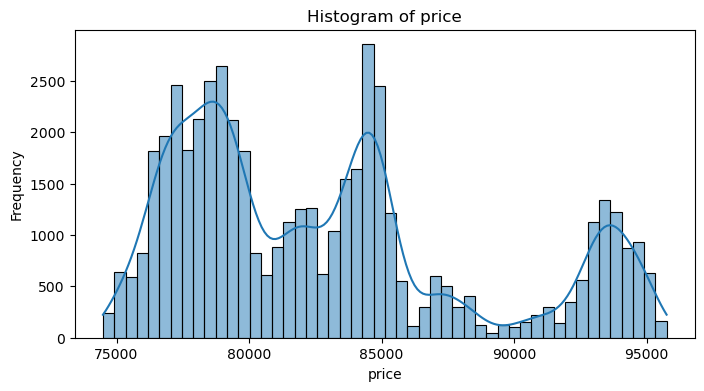

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_factor_histogram(df, factor_name, bins=50):
    data = df.select(pl.col(factor_name)).to_numpy().flatten()
    print(data.min(), data.max())  # ÁúãÁúãÊúÄÂ∞èÂÄºÂíåÊúÄÂ§ßÂÄº
    plt.figure(figsize=(8,4))
    sns.histplot(data, bins=bins, kde=True)
    plt.title(f"Histogram of {factor_name}")
    plt.xlabel(factor_name)
    plt.ylabel("Frequency")
    plt.show()

plot_factor_histogram(cleaned_df, FC)
plot_factor_histogram(cleaned_df, "price")


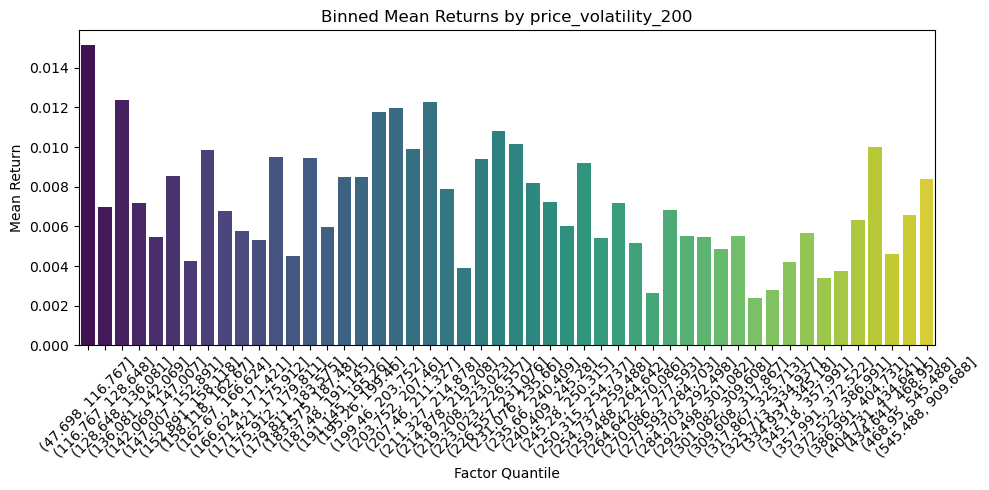

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_binned_returns(df: pl.DataFrame, factor_name: str, return_name: str, n_bins: int = 10):
    # ËΩ¨‰∏∫ pandasÔºå‰æø‰∫éÂàÜÁÆ±
    pdf = df.select([factor_name, return_name]).to_pandas()
    
    # ÂéªÈô§Áº∫Â§±ÂÄº
    pdf = pdf.dropna()

    # ÂàÜÁÆ±ÔºàÊåâÂõ†Â≠êÂÄºÂàÜ‰∏∫Á≠âÂàÜ quantile Ê°∂Ôºâ
    pdf["factor_bin"] = pd.qcut(pdf[factor_name], q=n_bins, duplicates="drop")

    # ËÆ°ÁÆóÊØè‰∏™ÂàÜÁÆ±ÁöÑÂπ≥ÂùáÊî∂Áõä
    bin_returns = pdf.groupby("factor_bin", observed=False)[return_name].mean().reset_index()
    # ÂèØËßÜÂåñ
    plt.figure(figsize=(10,5))
    sns.barplot(
        x=bin_returns["factor_bin"].astype(str),
        y=bin_returns[return_name],
        hue=bin_returns["factor_bin"].astype(str),  # Êää x ‰πüËÆæÁΩÆ‰∏∫ hue
        palette="viridis",
        legend=False
    )   
    plt.xticks(rotation=45)
    plt.title(f"Binned Mean Returns by {factor_name}")
    plt.xlabel("Factor Quantile")
    plt.ylabel("Mean Return")
    plt.tight_layout()
    plt.show()

plot_binned_returns(cleaned_df, FC, target_col, n_bins=50)


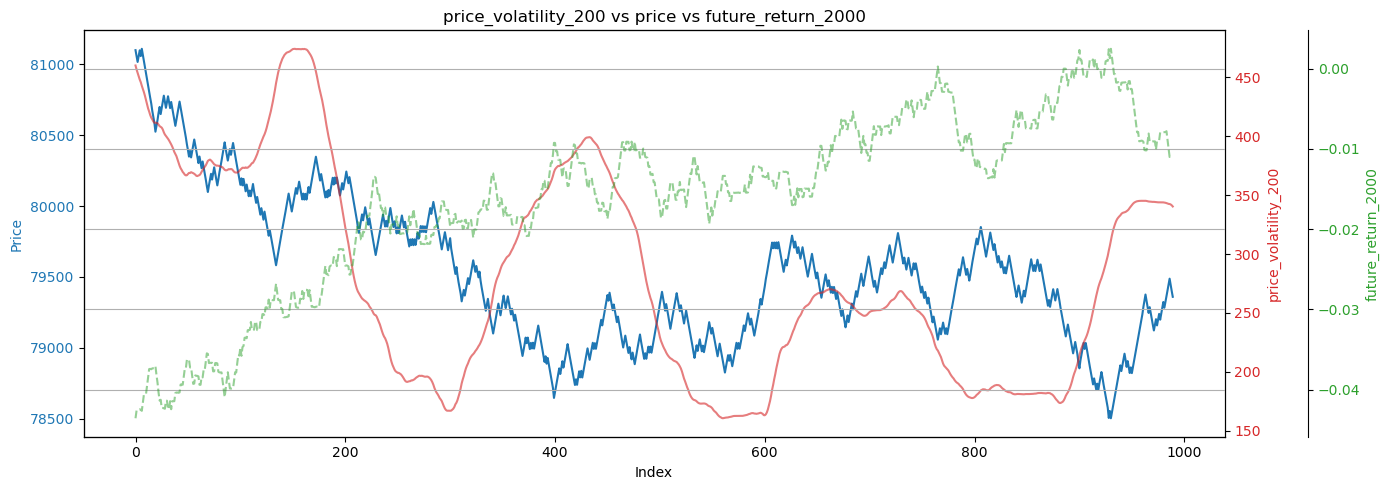

In [29]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).head(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # Á¨¨‰∏â‰∏™yËΩ¥ÂæÄÂè≥ÂÅèÁßª
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_factor_price_target(
    df=cleaned_df,
    factor_name=FC,
    price_col="price",
    target_col=target_col,
    n=990
)


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def single_asset_rolling_quantile_backtest(
    df,
    signal_col='signal',
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.9,
    short_quantile=0.1,
    window=500,
    fee=0.001,
    signal_mode='normal',
    plot=True,
):
    df = df.copy()
    if not np.issubdtype(df[timestamp_col].dtype, np.datetime64):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='us')
    df = df.sort_values(timestamp_col).reset_index(drop=True)

    if signal_mode == 'reverse':
        df[signal_col] = df[signal_col] * -1
        
    # Êî∂Áõä
    df['raw_ret'] = df[price_col].shift(-1) / df[price_col] - 1
    df = df.dropna(subset=['raw_ret'])

    # ÊªöÂä®ÂàÜ‰ΩçÊï∞Ôºà‰ΩøÁî®ËøáÂéªÁöÑÊï∞ÊçÆÔºâ
    rolling = df[signal_col].rolling(window=window, min_periods=window)
    df['long_thresh'] = rolling.quantile(long_quantile)
    df['short_thresh'] = rolling.quantile(short_quantile)
    df = df.dropna(subset=['long_thresh', 'short_thresh'])

    # ‰ªì‰ΩçÔºö‰ø°Âè∑ÂøÖÈ°ªÁøªËΩ¨ÊâçÊç¢‰ªìÔºåÈÅøÂÖçÈó™ÁÉÅ
    df['position'] = 0
    pos = 0
    positions = []

    for i, row in df.iterrows():
        signal = row[signal_col]
        long_th = row['long_thresh']
        short_th = row['short_thresh']

        if signal > long_th and pos != 1:
            pos = 1  # ÂÅöÂ§ö
        elif signal < short_th and pos != -1:
            pos = -1  # ÂÅöÁ©∫
        # Âê¶Âàô‰øùÊåÅÂéüÊù•‰ªì‰Ωç
        positions.append(pos)

    df['position'] = positions

    # Êç¢‰ªìÊâãÁª≠Ë¥π
    df['position_shift'] = df['position'].shift(1).fillna(0)
    df['turnover'] = (df['position'] != df['position_shift']).astype(int)
    df['strategy_ret'] = df['position_shift'] * df['raw_ret'] - df['turnover'] * fee
    df['cumulative'] = (1 + df['strategy_ret']).cumprod()
    df['buy_hold'] = df[price_col] / df[price_col].iloc[0]

    

    # ‚ûï Áª©ÊïàÊåáÊ†á
    trade_id = (df['position'] != df['position_shift']).cumsum()
    df['trade_id'] = trade_id
    trades = df[df['turnover'] == 1]
    trade_returns = []

    for tid in trades['trade_id'].unique():
        sub = df[df['trade_id'] == tid]
        if len(sub) > 1:
            trade_return = (1 + sub['strategy_ret']).prod() - 1
            trade_returns.append(trade_return)

    trade_returns = np.array(trade_returns)
    trade_count = len(trade_returns)
    win_rate = (trade_returns > 0).sum() / trade_count

    total_return = df['cumulative'].iloc[-1] - 1
    sharpe = df['strategy_ret'].mean() / df['strategy_ret'].std()
    max_dd = ((df['cumulative'].cummax() - df['cumulative']) / df['cumulative'].cummax()).max()
    total_fee = df['turnover'].sum() * fee

    if plot:
        print("\nüìä Á≠ñÁï•Áª©ÊïàÊåáÊ†á:")
    
        print(f"ÊÄª‰∫§ÊòìÊ¨°Êï∞: {trade_count}")
        print(f"ÊÄªÊâãÁª≠Ë¥π: {total_fee:.4f}ÔºàË¥πÁéá: {fee:.4f}Ôºâ")
    
        print(f"ËÉúÁéá: {win_rate:.2%}")
        print(f"ÊÄªÊî∂Áõä: {total_return:.2%}")
        print(f"Â§èÊôÆÊØîÁéá: {sharpe:.2f}")
        print(f"ÊúÄÂ§ßÂõûÊí§: {max_dd:.2%}")
    
        # ÁîªÂáÄÂÄºÊõ≤Á∫øÂíåÊåÅ‰ªì‰ø°Âè∑
        plt.figure(figsize=(14, 6))
        plt.plot(df[timestamp_col], df['cumulative'], label='Strategy')
        plt.plot(df[timestamp_col], df['buy_hold'], label='Buy & Hold', linestyle='--')
        plt.fill_between(df[timestamp_col], 0.98, 1.02, where=df['position'] == 1, color='green', alpha=0.1, label='Long')
        plt.fill_between(df[timestamp_col], 0.98, 1.02, where=df['position'] == -1, color='red', alpha=0.1, label='Short')
        plt.title('Rolling Quantile Backtest')
        plt.legend()
        plt.grid(True)
        plt.show()

    return df


In [31]:
def backtest_all_signals(
    df,
    signal_cols,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.95,
    short_quantile=0.05,
    window=500,
    fee=0.001,
    top_n=50
):
    results = []

    for signal_col in tqdm(signal_cols, desc="Backtesting Signals"):  # ‚¨ÖÔ∏è Âä†ËøõÂ∫¶Êù°        
        df_result = single_asset_rolling_quantile_backtest(
            df=df,
            signal_col=signal_col,
            price_col=price_col,
            timestamp_col=timestamp_col,
            long_quantile=long_quantile,
            short_quantile=short_quantile,
            window=window,
            fee=fee,
            plot=False  # ÊîπÊàêÂèØÊéßÁöÑ
        )
        
        # ÂèñÊúÄÂêé‰∏ÄË°åÁöÑÁ¥ØËÆ°Êî∂ÁõäÁ≠â‰ø°ÊÅØ
        total_return = df_result['cumulative'].iloc[-1] - 1
        sharpe = df_result['strategy_ret'].mean() / df_result['strategy_ret'].std() if df_result['strategy_ret'].std() > 0 else 0
        max_dd = ((df_result['cumulative'].cummax() - df_result['cumulative']) / df_result['cumulative'].cummax()).max()
        total_fee = df_result['turnover'].sum() * fee

        results.append({
            'signal': signal_col,
            'total_return': total_return,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'total_fee': total_fee,
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(by='total_return', ascending=False).reset_index(drop=True)

    # ÊâìÂç∞Ââç top_n ÁöÑÂõ†Â≠êÊî∂ÁõäÁéá
    print(f"\nüìä Ââç {top_n} Âõ†Â≠êÔºàÊåâÊÄªÊî∂ÁõäÊéíÂ∫èÔºâ:")
    print(result_df.head(top_n).round(4))

    return result_df

# if exclude_prefixes is None:
#         exclude_prefixes = []

# factor_cols = [
#     col for col in cleaned_df.columns
#     if all(not col.startswith(prefix) for prefix in exclude_prefixes)
#     and not col.startswith("future_return_")
#     and col != "price"
# ]




üìä Á≠ñÁï•Áª©ÊïàÊåáÊ†á:
ÊÄª‰∫§ÊòìÊ¨°Êï∞: 61
ÊÄªÊâãÁª≠Ë¥π: 0.0610ÔºàË¥πÁéá: 0.0010Ôºâ
ËÉúÁéá: 40.98%
ÊÄªÊî∂Áõä: -20.41%
Â§èÊôÆÊØîÁéá: -0.01
ÊúÄÂ§ßÂõûÊí§: 21.81%


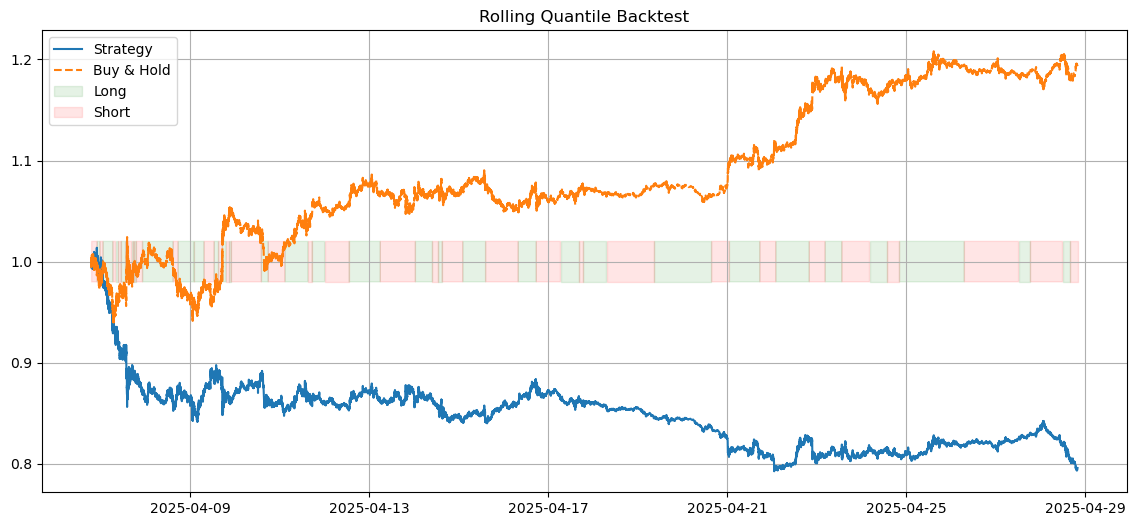

In [122]:
factor = 'alt_top_long_short_account_ratio_data_longShortRatio_SPREAD_X_MAG_alt_factor_short_term_oi_trend'
a = single_asset_rolling_quantile_backtest(
    cleaned_df.to_pandas(),
    signal_col=factor,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.9,
    short_quantile=0.1,
    window=500,
    fee=0.001,
    signal_mode="reverse",
)



üìä Á≠ñÁï•Áª©ÊïàÊåáÊ†á:
ÊÄª‰∫§ÊòìÊ¨°Êï∞: 83
ÊÄªÊâãÁª≠Ë¥π: 0.0830ÔºàË¥πÁéá: 0.0010Ôºâ
ËÉúÁéá: 54.22%
ÊÄªÊî∂Áõä: 6.22%
Â§èÊôÆÊØîÁéá: 0.00
ÊúÄÂ§ßÂõûÊí§: 10.96%


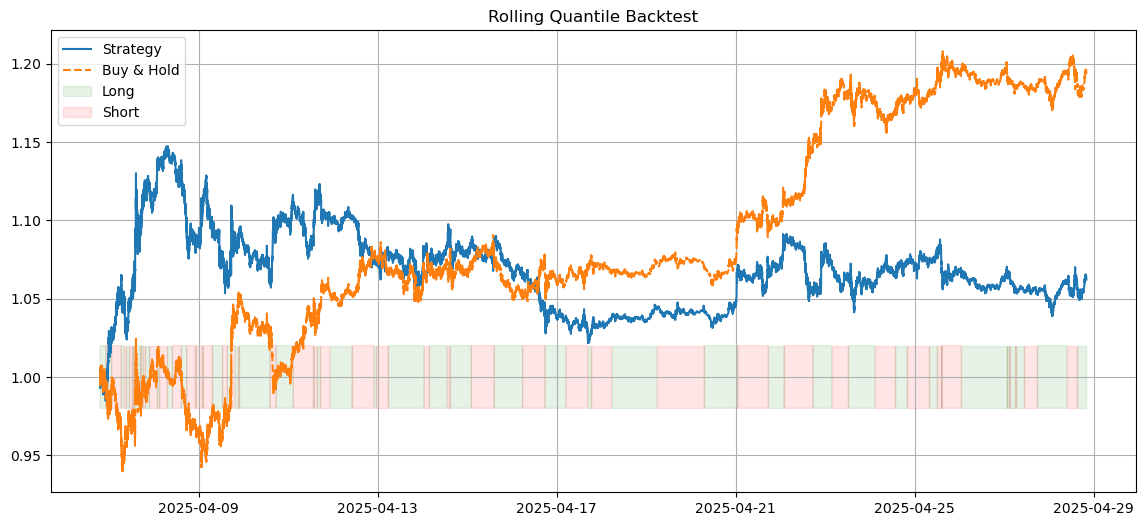

In [134]:
a = single_asset_rolling_quantile_backtest(
    cleaned_df.to_pandas(),
    signal_col=factor,
    price_col='price',
    timestamp_col='timestamp',
    long_quantile=0.55,
    short_quantile=0.45,
    window=500,
    fee=0.001,
)

In [202]:
def cal_z_score(x: pl.Expr, mean: pl.Expr, std: pl.Expr) -> pl.Expr:
    return (x - mean) / std

def scaled_sigmoid_expr(x: pl.Expr, start: pl.Expr, end: pl.Expr) -> pl.Expr:
    n = (start - end).abs()
    score = pl.lit(2) / (
            pl.lit(1) + (pl.lit(2.71828) ** (-pl.lit(4_000_000).log(10) * ((x - start - n) / n) + pl.lit(5e-3).log(10)))
    )
    return score / pl.lit(2)

def rolling_scaled_sigmoid_expr(
        x: str,
        mean_col: str,
        std_col: str,
        max_col: str,
        min_col: str,
) -> pl.Expr:
    return (
        pl.when(pl.col(std_col) == 0)
        .then(pl.lit(0.5))
        .otherwise(
            scaled_sigmoid_expr(
                cal_z_score(pl.col(x), pl.col(mean_col), pl.col(std_col)),
                pl.col(min_col),
                pl.col(max_col)
            )
        )
        .alias(f"{x}_scaled")  # ÂàóÂëΩÂêç
    )

def rolling_sum_expr(col_name: str, window: int) -> pl.Expr:
    return pl.col(col_name).rolling_sum(window).alias(f"{col_name}_sum_{window}")

def rolling_normalize_data(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
        and not col.startswith("future_return_")
        and not col.endswith('_scaled')  # scaled ÊòØÊúÄÁªà‰∫ßÁâ©Ôºå‰øùÁïô
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_rolling_max') or
            col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_mean(window).alias(f"{column}_rolling_mean"),
            pl.col(column).rolling_std(window).alias(f"{column}_rolling_std"),
            pl.col(column).rolling_max(window).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
        f"{column}_rolling_mean" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_std" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_max" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_min" for column in columns_to_normalize
    ]

    normalized_df = (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_scaled_sigmoid_expr(
                column,
                f"{column}_rolling_mean",
                f"{column}_rolling_std",
                f"{column}_rolling_max",
                f"{column}_rolling_min",
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

    return normalized_df

def rolling_minmax_scaled_expr(
    col: str,
    min_col: str,
    max_col: str,
    scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .alias(scaled_col)
    )
    
def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['price', 'timestamp', 'timestamp_dt', 'symbol']
        and not col.startswith("future_return_")
        and not col.endswith('_scaled')  # scaled ÊòØÊúÄÁªà‰∫ßÁâ©Ôºå‰øùÁïô
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_rolling_max') or
            col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window).alias(f"{column}_rolling_min"),
        ])


    intermediate_cols = [
        f"{column}_rolling_max" for column in columns_to_normalize
    ] + [
        f"{column}_rolling_min" for column in columns_to_normalize
    ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )


In [240]:
import polars as pl
import numpy as np

np.random.seed(42)
n = 200

df = pl.DataFrame({
    "timestamp": np.arange(n),

    # Âõ¥Áªï 1 Ê≥¢Âä®Ôºà‰æãÂ¶ÇÔºöbuy/sell ratioÔºâ
    "ratio_feature": np.abs(np.random.randn(n) * 1 + 1.0),

    # Âõ¥Áªï 100 Ê≥¢Âä®ÔºàÂ¶Ç‰ª∑Ê†ºÔºâ
    "price_feature": np.cumsum(np.random.randn(n) * 0.3 + 0.1),

    # Âõ¥Áªï 500000 Ê≥¢Âä®ÔºàÂ¶ÇËµÑÈáëÊµÅÈáèÔºâ
    "fund_feature": np.cumsum(np.random.randn(n) * 1e4 + 500_000),
})


     timestamp  ratio_feature  price_feature  fund_feature  \
0            0       1.496714       0.207336  4.840557e+05   
1            1       0.861736       0.475572  9.780620e+05   
2            2       1.647689       0.900487  1.478114e+06   
3            3       2.523030       1.316628  1.978584e+06   
4            4       0.765847       1.003327  2.474084e+06   
..         ...            ...            ...           ...   
195        195       1.385317      24.522887  9.784185e+07   
196        196       0.116143      24.108947  9.833915e+07   
197        197       1.153725      24.615108  9.882936e+07   
198        198       1.058209      24.680746  9.932492e+07   
199        199       0.142970      25.152091  9.982869e+07   

     ratio_feature_scaled  price_feature_scaled  fund_feature_scaled  
0                     NaN                   NaN                  NaN  
1                     0.0                   1.0                  1.0  
2                     1.0                 

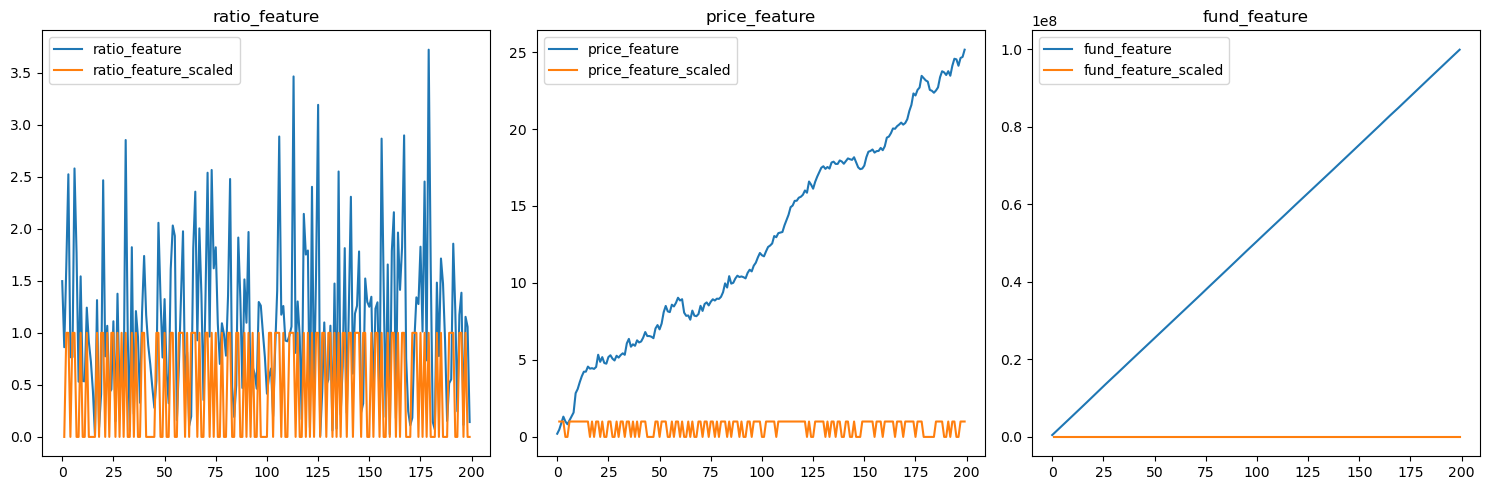

In [250]:
import matplotlib.pyplot as plt

normalized_df = rolling_minmax_normalize(df, window=2).to_pandas()
print(normalized_df)
plt.figure(figsize=(15, 5))

for i, feature in enumerate(["ratio_feature", "price_feature", "fund_feature"]):
    plt.subplot(1, 3, i+1)
    plt.plot(normalized_df[f"{feature}"], label=feature)
    plt.plot(normalized_df[f"{feature}_scaled"], label=f"{feature}_scaled")
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.show()


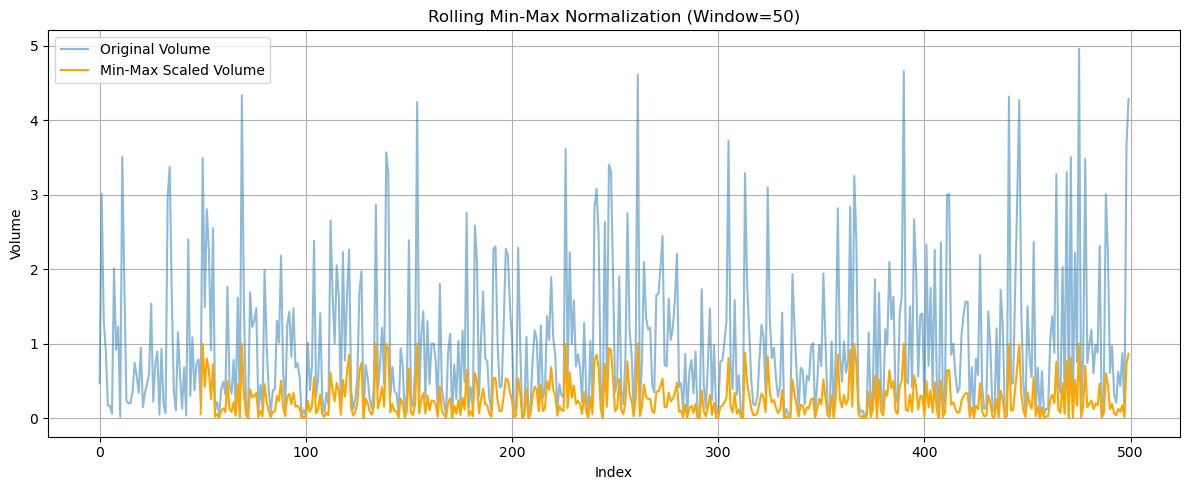

In [258]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Á§∫‰æãÊï∞ÊçÆ
np.random.seed(42)
n_rows = 500

df = pl.DataFrame({
    "idx": np.arange(n_rows, dtype=np.int64), # ‰ΩøÁî® i64 Á±ªÂûãÁöÑÊó∂Èó¥Êà≥
    "factor": np.random.rand(n_rows) * 100,
    "future_return": np.random.randn(n_rows) * 0.01 # ÈöèÊú∫Êî∂Áõä
})

# ‰∏∫‰∫ÜÊºîÁ§∫Ë¥üÁõ∏ÂÖ≥ÔºåÊàë‰ª¨ÂèØ‰ª•Á®çÂæÆË∞ÉÊï¥‰∏Ä‰∏ã future_return
df = df.with_columns(
    (pl.col("future_return") - (pl.col("factor") / 1000 - 0.05)).alias("future_return")
)

# Á°Æ‰øù 'idx' ÂàóÂ∑≤ÊéíÂ∫èÔºåËøôÊòØ rolling ÁöÑË¶ÅÊ±Ç
df = df.sort("idx")

# ÂÆö‰πâÊªöÂä®Á™óÂè£Â§ßÂ∞è
window_size = 30

# --- ËÆ°ÁÆóÊªöÂä® Spearman IC ---

# Ëá™ÂÆö‰πâÂáΩÊï∞ÔºöÂú®ÊØè‰∏™ÁªÑÂÜÖËÆ°ÁÆó Spearman Áõ∏ÂÖ≥ÊÄß
def calculate_spearman_in_window(df_window: pl.DataFrame) -> pl.DataFrame:
    if len(df_window) < 2: # Áõ∏ÂÖ≥ÊÄßËá≥Â∞ëÈúÄË¶Å‰∏§‰∏™Êï∞ÊçÆÁÇπ
        return pl.DataFrame({"rolling_ic": [np.nan]})

    # ËΩ¨Êç¢‰∏∫SeriesÔºåÁÑ∂ÂêéËÆ°ÁÆóÊéíÂêç
    factor_ranks = df_window["factor"].rank(method="average")
    future_return_ranks = df_window["future_return"].rank(method="average")

    # ËÆ°ÁÆó Pearson Áõ∏ÂÖ≥ÊÄßÔºåËøôÂ∞±ÊòØ Spearman Áõ∏ÂÖ≥ÊÄß
    spearman_corr = factor_ranks.corr(future_return_ranks, method="pearson")

    # Á°Æ‰øùËøîÂõûÁöÑDataFrameÁöÑÂàóÂêçÂíåÁ±ªÂûã‰∏éÈ¢ÑÊúü‰∏ÄËá¥
    return pl.DataFrame({"rolling_ic": [spearman_corr]}, schema={"rolling_ic": pl.Float64}) # <-- Á°Æ‰øùËøôÈáåÊúâÊòéÁ°ÆÁöÑschemaÂÆö‰πâ

# ‰ΩøÁî® rolling().agg() Âíå map_groups Êù•Â∫îÁî®Ëá™ÂÆö‰πâÂáΩÊï∞
df_with_rolling_ic = df.rolling(
    index_column="idx",
    period=f"{window_size}i",
    closed="right"
).agg(
    # ‰øÆÊ≠£ÔºöÁßªÈô§ map_groups ÁöÑ schema ÂèÇÊï∞ÔºåËÆ© Polars Ëá™Ë°åÊé®Êñ≠ÊàñÂú®ÂáΩÊï∞ÂÜÖÈÉ®ËøîÂõûÁöÑDataFrame‰∏≠ÊòéÁ°Æ
    pl.map_groups(
        exprs=[pl.col("factor"), pl.col("future_return")],
        function=calculate_spearman_in_window,
        # schema={"rolling_ic": pl.Float64} # <-- ÁßªÈô§Ëøô‰∏™ÂèÇÊï∞
    ).alias("rolling_ic_computed") # ÂèØ‰ª•Áªô‰∏Ä‰∏™‰∏¥Êó∂ÁöÑaliasÔºåÂ¶ÇÊûúÈúÄË¶ÅÁöÑËØù
)

# ÂêàÂπ∂ÂõûÂéüÂßãDataFrame (Â¶ÇÊûúÈúÄË¶Å)
# Ê≥®ÊÑèÔºöjoin Êó∂‰ΩøÁî® map_groups ËøîÂõûÁöÑÂàóÂêç
df = df.join(df_with_rolling_ic, on="idx", how="left")

# Â¶ÇÊûú‰Ω†‰πãÂâçÊ≤°ÊúâÂú® calculate_spearman_in_window ‰∏≠‰∏∫ËæìÂá∫ÂàóÂëΩÂêçÔºå
# Âπ∂‰∏î map_groups ‰πüÊ≤°ÊúâÊåáÂÆö aliasÔºåÈÇ£‰πàËæìÂá∫ÂàóÂêçÂèØËÉΩ‰ºöÊòØ 'map' ÊàñÂÖ∂‰ªñÈªòËÆ§Âêç„ÄÇ
# Âú®ËøôÈáåÔºåÊàë‰ª¨‰øÆÊîπ‰∫Ü calculate_spearman_in_window Á°Æ‰øùÂÆÉËøîÂõû 'rolling_ic' Âàó„ÄÇ
# Âπ∂‰∏î map_groups ÁöÑ alias ËÆæÁΩÆ‰∏∫ "rolling_ic_computed"ÔºåÊâÄ‰ª•ËøôÈáåÈúÄË¶ÅË∞ÉÊï¥
# ËÆ©Êàë‰ª¨Êää map_groups ÁöÑ alias ËÆæ‰∏∫ÊúÄÁªàÊÉ≥Ë¶ÅÁöÑÂàóÂêçÔºåÊàñËÄÖËÆ©ÂÆÉ‰∏çÂëΩÂêçÔºåÁÑ∂ÂêéÂêéÈù¢ÈáçÂëΩÂêç„ÄÇ
# ‰∏∫‰∫ÜÁÆÄÊ¥ÅÔºåÊàë‰ª¨ËÆ© map_groups ËøîÂõûÁöÑÂàóÂêçÂ∞±ÊòØÊàë‰ª¨ÊÉ≥Ë¶ÅÁöÑÔºåÁÑ∂Âêé join„ÄÇ

# ÈáçÊñ∞‰øÆÊîπ df_with_rolling_ic ÁöÑÁîüÊàêÔºåÁ°Æ‰øùÂàóÂêç‰∏ÄËá¥ÊÄß
# ËøôÈáåÊúÄÁÆÄÂçïÁöÑÊñπÊ≥ïÊòØËÆ© calculate_spearman_in_window ÂáΩÊï∞ÁöÑËæìÂá∫DataFrameÂ∞±Âè´ 'rolling_ic'
# ÁÑ∂Âêé map_groups Âá∫Êù•ÁöÑÁªìÊûú‰πüÂè´ 'rolling_ic'
df_with_rolling_ic = df.rolling(
    index_column="idx",
    period=f"{window_size}i",
    closed="right"
).agg(
    pl.map_groups(
        exprs=[pl.col("factor"), pl.col("future_return")],
        function=calculate_spearman_in_window,
    ).alias("rolling_ic") # <-- Áõ¥Êé•Âú®ËøôÈáåÁªôÊúÄÁªàÁöÑÂàóÂêç
)

# ÂêàÂπ∂ÂõûÂéüÂßãDataFrame (Â¶ÇÊûúÈúÄË¶Å)
df = df.join(df_with_rolling_ic, on="idx", how="left")

print("DataFrame with Rolling Spearman IC:")
print(df.head())
print(df.tail())

# Ê£ÄÊü•ÁªìÊûú
print("\nRolling IC Description:")
print(df["rolling_ic"].describe())

# ÁªòÂà∂ÊªöÂä®IC
plt.figure(figsize=(15, 6))
plt.plot(df["idx"], df["rolling_ic"])
plt.title(f"{window_size}-Period Rolling Spearman IC (i64 Index)")
plt.xlabel("Index (i64 Time)")
plt.ylabel("Rolling IC")
plt.grid(True)
plt.show()

PanicException: python function failed: list indices must be integers or slices, not str